In [2]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context = 'notebook', #mostly controls relative sizes of things on plot 
                        #The base context is “notebook”, and the other contexts are “paper”, “talk”, and “poster”
        style = 'darkgrid', #dict, None, or one of {darkgrid, whitegrid, dark, white, ticks}
        palette = 'deep', # Should be something that color_palette() can process.
        font_scale = 1, 
        color_codes = False, 
        rc = None)

# from IPython.core.interactiveshell import InteractiveShell 
# InteractiveShell.ast_node_interactivity = 'last_expr' 
# setting = "all" allows multiple outputs to be displayed for a given input cell. don't use w plotting!

from IPython.display import display

import ast

%matplotlib notebook
##%matplotlib inline

pd.__version__ , np.__version__ #,  matplotlib.__version__, sns.__version__

('0.23.3', '1.14.2')

In [3]:
from sklearn.model_selection import train_test_split, learning_curve, KFold, StratifiedKFold, \
                                    ShuffleSplit, GridSearchCV, RandomizedSearchCV, cross_val_predict

from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.tree import DecisionTreeClassifier

from sklearn.externals import joblib

In [4]:
cd '/Users/DonBunk/Desktop/Google Drive/data_science/Python_Projects/Home_Credit_Default_Risk/'

/Users/DonBunk/Desktop/Google Drive/data_science/Python_Projects/Home_Credit_Default_Risk


In [5]:
from Home_Credit_package.master_pipeline import master_pipeline
from Home_Credit_package.Dons_functions import balanced_sample

In [6]:
path_to_models = 'saved_models/level_2_models/'

level_2_metafeats_save_path = 'final_metafeats_and_predictions/level_2/level_2_meta_feats/'
level_2_preds_save_path = 'final_metafeats_and_predictions/level_2/level_2_final_predictions/'

# load this

## load dfs

In [7]:
# load the training and test data, and merge each with their level_1 metafeatures. 

TRAIN_path = 'wrangling/TRAINING_DATA_create_final_wrangled_csv/'
o_TRAIN_df = pd.read_csv(TRAIN_path + 'complete_initial_wrangled_data.csv', index_col = 'SK_ID_CURR')
TRAIN_L1_mf_path = 'level_1_ensembling/'
TRAIN_level_1_metafeatures_df = pd.read_csv(TRAIN_L1_mf_path + 'FINAL_level_1_meta_features_df.csv', index_col = 'SK_ID_CURR')
TRAIN_df = pd.merge(o_TRAIN_df, TRAIN_level_1_metafeatures_df, left_index=True, right_index=True, how = 'outer' )


TEST_path = 'wrangling/TEST_DATA_create_final_wrangled_csv/'
o_TEST_df = pd.read_csv(TEST_path + 'complete_initial_wrangled_data.csv', index_col = 'SK_ID_CURR')
TEST_L1_mf_path = 'final_metafeats_and_predictions/level_1/level_1_meta_feats/'
TEST_level_1_metafeatures_df = pd.read_csv(TEST_L1_mf_path + 'FINAL_level_1_meta_features_df.csv', index_col = 'SK_ID_CURR')
TEST_df = pd.merge(o_TEST_df, TEST_level_1_metafeatures_df, left_index=True, right_index=True, how = 'outer' )

In [8]:
raw_level_2_new_features_df = pd.DataFrame(TEST_df.index)
raw_level_2_new_features_df.set_index('SK_ID_CURR', inplace=True)

# models with only EXT SOURCES + level 1 final scores.                                     

In [9]:
minimal_feats = ['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3',
                 'pwr_rescale_RanFor_EXTpoly', 'pwr_rescale_RanFor_AllFeats', 
                 'pwr_rescale_LogReg_EXTpoly','pwr_rescale_LogReg_AllFeats', 
                 'pwr_rescale_MLP_AllFeats']

In [10]:
total_df_piped, final_feature_list, total_pipeline, trans_list = master_pipeline(df_in = TRAIN_df[minimal_feats],
                                                                                 int_cutoff=20, 
                                                                                 poly_deg=4, 
                                                                                 feats_with_interaction=[]
                                                                                 )

Total original feat len is 8. Sum of feats is 8.
Final array is length 40. final feature list is length 40.


In [11]:
TEST_piped = total_pipeline.transform(TEST_df)

### random forest
Kaggle: Private: 0.75996 Public: 0.76357

In [12]:
RanFor_EXTpoly_Level_2 = joblib.load(path_to_models + 'RanFor_EXTpoly_Level_2.joblib')
RanFor_EXTpoly_Level_2

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=11, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [13]:
preds = RanFor_EXTpoly_Level_2.predict_proba(TEST_piped)
val_scores = [x[1]for x in preds]

In [14]:
raw_level_2_new_features_df['RanFor_EXTpoly_Level2'] = val_scores

In [15]:
this_model = 'RanFor_EXTpoly_Level2'

raw_level_2_new_features_df[[this_model]].to_csv(level_2_preds_save_path + this_model + '.csv', 
                                                 columns = list(raw_level_2_new_features_df[[this_model]].columns),
                                                 header = ['TARGET'],
                                                 )

### log reg
Kaggle: Private: 0.76157 Publice: 0.76274

In [16]:
LogReg_EXTpoly_Level_2 = joblib.load(path_to_models + 'LogReg_EXTpoly_Level_2.joblib')
LogReg_EXTpoly_Level_2

LogisticRegression(C=88.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [17]:
preds = LogReg_EXTpoly_Level_2.predict_proba(TEST_piped)
val_scores = [x[1]for x in preds]

In [18]:
raw_level_2_new_features_df['LogReg_EXTpoly_Level2'] = val_scores

In [19]:
this_model = 'LogReg_EXTpoly_Level2'

raw_level_2_new_features_df[[this_model]].to_csv(level_2_preds_save_path + this_model + '.csv', 
                                                 columns = list(raw_level_2_new_features_df[[this_model]].columns),
                                                 header = ['TARGET'],
                                                 )

### MLP Classifier.
Kaggle: Private: 0.76199 Public: 0.76393

In [20]:
MLP_EXTpoly_Level_2 = joblib.load(path_to_models + 'MLP_EXTpoly_Level_2.joblib')
MLP_EXTpoly_Level_2

MLPClassifier(activation='relu', alpha=0.15, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(67,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [21]:
preds = MLP_EXTpoly_Level_2.predict_proba(TEST_piped)
val_scores = [x[1]for x in preds]

In [22]:
raw_level_2_new_features_df['MLP_EXTpoly_Level2'] = val_scores

In [23]:
this_model = 'MLP_EXTpoly_Level2'

raw_level_2_new_features_df[[this_model]].to_csv(level_2_preds_save_path + this_model + '.csv', 
                                                 columns = list(raw_level_2_new_features_df[[this_model]].columns),
                                                 header = ['TARGET'],
                                                 )

# models with all features

In [24]:
total_df_piped, final_feature_list, total_pipeline, trans_list = master_pipeline(df_in = TRAIN_df,
                                                                                 int_cutoff=20, 
                                                                                 poly_deg=4, 
                                                                                 feats_with_interaction=[]
                                                                                 )

Total original feat len is 90. Sum of feats is 90.
Final array is length 443. final feature list is length 443.


In [25]:
TEST_piped = total_pipeline.transform(TEST_df)

### random forest
Kaggle: Private: 0.75813 Public:0.76088

In [26]:
RanFor_AllFeats_Level_2 = joblib.load(path_to_models + 'RanFor_AllFeats_Level_2.joblib')
RanFor_AllFeats_Level_2

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=16, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=550, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [27]:
preds = RanFor_AllFeats_Level_2.predict_proba(TEST_piped)
val_scores = [x[1]for x in preds]

In [28]:
raw_level_2_new_features_df['RanFor_AllFeats_Level2'] = val_scores

In [29]:
this_model = 'RanFor_AllFeats_Level2'

raw_level_2_new_features_df[[this_model]].to_csv(level_2_preds_save_path + this_model + '.csv', 
                                                 columns = list(raw_level_2_new_features_df[[this_model]].columns),
                                                 header = ['TARGET'],
                                                 )

### feature importance for random forest model above

In [30]:
# all features and importances
feat_imports_raw = list(zip(final_feature_list, RanFor_AllFeats_Level_2.feature_importances_))
# strip off details (polynomial order etc)
feat_imports_stripped_details_df = pd.DataFrame( [(ast.literal_eval(x[0])[0], x[1]) for x in feat_imports_raw],
                                               columns = ['Feature','Importance'])
# group by 'base' feature and sum
feats_grouped = feat_imports_stripped_details_df['Importance'].groupby(feat_imports_stripped_details_df['Feature'])
final_feat_imports = feats_grouped.sum().to_frame()
# make index into column, and order by Importance
final_feat_imports.reset_index(inplace=True)
final_feat_imports.sort_values(by = 'Importance', ascending=False, inplace=True)

<IPython.core.display.Javascript object>


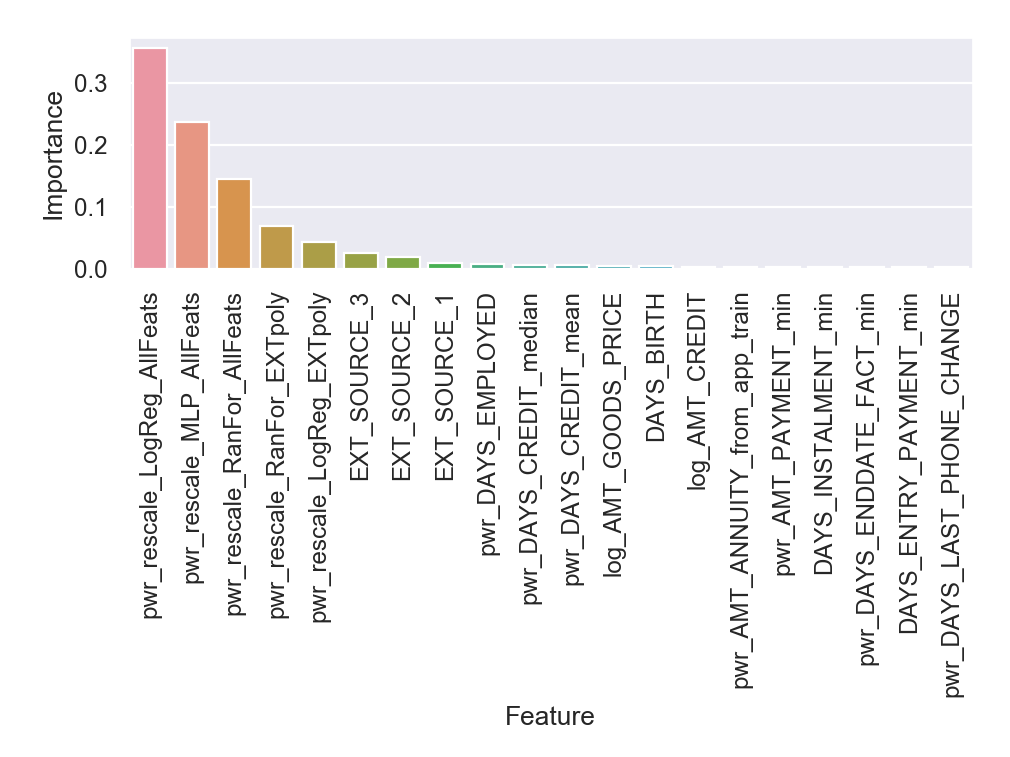

In [31]:
sns.barplot(x="Feature", y="Importance", data=final_feat_imports[:20])
plt.xticks(rotation=90)
plt.tight_layout()

### log reg
Kaggle: Private: 0.76158 Public: 0.76412

In [46]:
LogReg_AllFeats_Level_2 = joblib.load(path_to_models + 'LogReg_AllFeats_Level_2.joblib')
LogReg_AllFeats_Level_2

LogisticRegression(C=179.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [47]:
preds = LogReg_AllFeats_Level_2.predict_proba(TEST_piped)
val_scores = [x[1]for x in preds]

In [48]:
raw_level_2_new_features_df['LogReg_AllFeats_Level2'] = val_scores

In [49]:
this_model = 'LogReg_AllFeats_Level2'

raw_level_2_new_features_df[[this_model]].to_csv(level_2_preds_save_path + this_model + '.csv', 
                                                 columns = list(raw_level_2_new_features_df[[this_model]].columns),
                                                 header = ['TARGET'],
                                                 )

### MLP Classifier
Kaggle: Private: 0.75735 Public: 0.76152

In [50]:
MLP_AllFeats_Level_2 = joblib.load(path_to_models + 'MLP_AllFeats_Level_2.joblib')
MLP_AllFeats_Level_2

MLPClassifier(activation='relu', alpha=0.05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(55,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [51]:
preds = MLP_AllFeats_Level_2.predict_proba(TEST_piped)
val_scores = [x[1]for x in preds]

In [52]:
raw_level_2_new_features_df['MLP_AllFeats_Level2'] = val_scores

In [53]:
this_model = 'MLP_AllFeats_Level2'

raw_level_2_new_features_df[[this_model]].to_csv(level_2_preds_save_path + this_model + '.csv', 
                                                 columns = list(raw_level_2_new_features_df[[this_model]].columns),
                                                 header = ['TARGET'],
                                                 )

# Final level 2 metafeatures

In [54]:
def pwr_and_rescale(df_col, pwr):
    temp_col = df_col**pwr
    return (temp_col - min(temp_col)) /( max(temp_col) - min(temp_col))

In [55]:
FINAL_level_2_new_features_df = pd.DataFrame()

In [58]:
feat = 'RanFor_EXTpoly_Level2'
FINAL_level_2_new_features_df['pwr_rescale_'+ feat] = pwr_and_rescale(+raw_level_2_new_features_df[feat], 1/5)

feat = 'LogReg_EXTpoly_Level2'
FINAL_level_2_new_features_df['pwr_rescale_'+ feat] = pwr_and_rescale(+raw_level_2_new_features_df[feat], 1/3.5)

feat = 'MLP_EXTpoly_Level2'
FINAL_level_2_new_features_df['pwr_rescale_'+ feat] = pwr_and_rescale(+raw_level_2_new_features_df[feat], 1/4)

feat = 'RanFor_AllFeats_Level2'
FINAL_level_2_new_features_df['pwr_rescale_'+ feat] = pwr_and_rescale(+raw_level_2_new_features_df[feat], 1/7)

feat = 'LogReg_AllFeats_Level2'
FINAL_level_2_new_features_df['pwr_rescale_'+ feat] = pwr_and_rescale(+raw_level_2_new_features_df[feat], 1/4)

feat = 'MLP_AllFeats_Level2'
FINAL_level_2_new_features_df['pwr_rescale_'+ feat] = pwr_and_rescale(+raw_level_2_new_features_df[feat], 1/4)


In [59]:
pwd

'/Users/DonBunk/Desktop/Google Drive/data_science/Python_Projects/Home_Credit_Default_Risk'

In [61]:
FINAL_level_2_new_features_df.to_csv(level_2_metafeats_save_path + 'FINAL_level_2_meta_features_df.csv', columns = list(FINAL_level_2_new_features_df.columns))